In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
import json
import pandas as pd

sys.path.insert(0, '/home/garren/HPC Files/Pure RK PMF')

from Post_procs import Post_process

/tmp/ipykernel_12464/2764910561.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
functional_groups = np.array(['all'])
include_clusters = True
include_zeros = True
refT = True
ARD = False
inf_type = 'MAP'

In [4]:
post_obj = Post_process(include_clusters=include_clusters,
                        include_zeros=include_zeros,
                        refT=refT,
                        ARD=ARD,
                        inf_type=inf_type,
                        functional_groups=functional_groups)

In [5]:
A = post_obj.get_tensors()
rank_idx = np.where(post_obj.ranks == 9)[0][0]

In [8]:
c_all = post_obj.c_all

In [9]:
mix_plot = np.array(['Heptanoic acid + n-Hexane',
                     'n-Hexane + Cyclohexane',
                     'n-Hexane + Methanol',
                     'n-Nonane + Propyl acetate'])
c1_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,0][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
c2_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,1][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
Idx_plot = np.stack((c1_plot, c2_plot), axis=1)

In [21]:
y_MC_interps_plot = post_obj.extract_interps(A=A,Idx=Idx_plot)[rank_idx]

In [15]:
data_dict = post_obj.get_reconstructed_values(A=A)

In [16]:
x2_int = np.array(json.load(open(post_obj.data_file, 'r'))['x2_int'])
T2_int = np.array(json.load(open(post_obj.data_file, 'r'))['T2_int'])
x_MC = np.concatenate([x2_int for _ in T2_int])
T_MC = np.concatenate([t*np.ones_like(x2_int) for t in T2_int])
jitter = json.load(open(post_obj.data_file, 'r'))['jitter']
v_MC = np.array(json.load(open(post_obj.data_file, 'r'))['v_MC'])

K_MC = post_obj.K(x_MC, x_MC, T_MC, T_MC) + (jitter+v_MC)*np.eye(x_MC.shape[0])
L_MC = np.linalg.cholesky(K_MC)
L_MC_inv = np.linalg.inv(L_MC)
K_MC_inv = L_MC_inv.T @ L_MC_inv
del K_MC, L_MC

mix_all = np.char.add(np.char.add(post_obj.c_all[Idx_plot[:,0]], ' + '), post_obj.c_all[Idx_plot[:,1]])
unique_mix, idx = np.unique(mix_all, return_index=True)
unique_mix = unique_mix[np.argsort(idx)]
df_UNIFAC = pd.read_excel(post_obj.excel_plots_known, sheet_name='Training_Plots')
UNIFAC_mix = np.char.add(np.char.add(df_UNIFAC['Component 1'].to_numpy().astype(str), ' + '), df_UNIFAC['Component 2'].to_numpy().astype(str))

exp_mix = np.char.add(np.char.add(data_dict['c1'], ' + '), data_dict['c2'])

In [17]:
matplotlib.use('qt5agg')
%matplotlib inline

In [47]:
from matplotlib.lines import Line2D

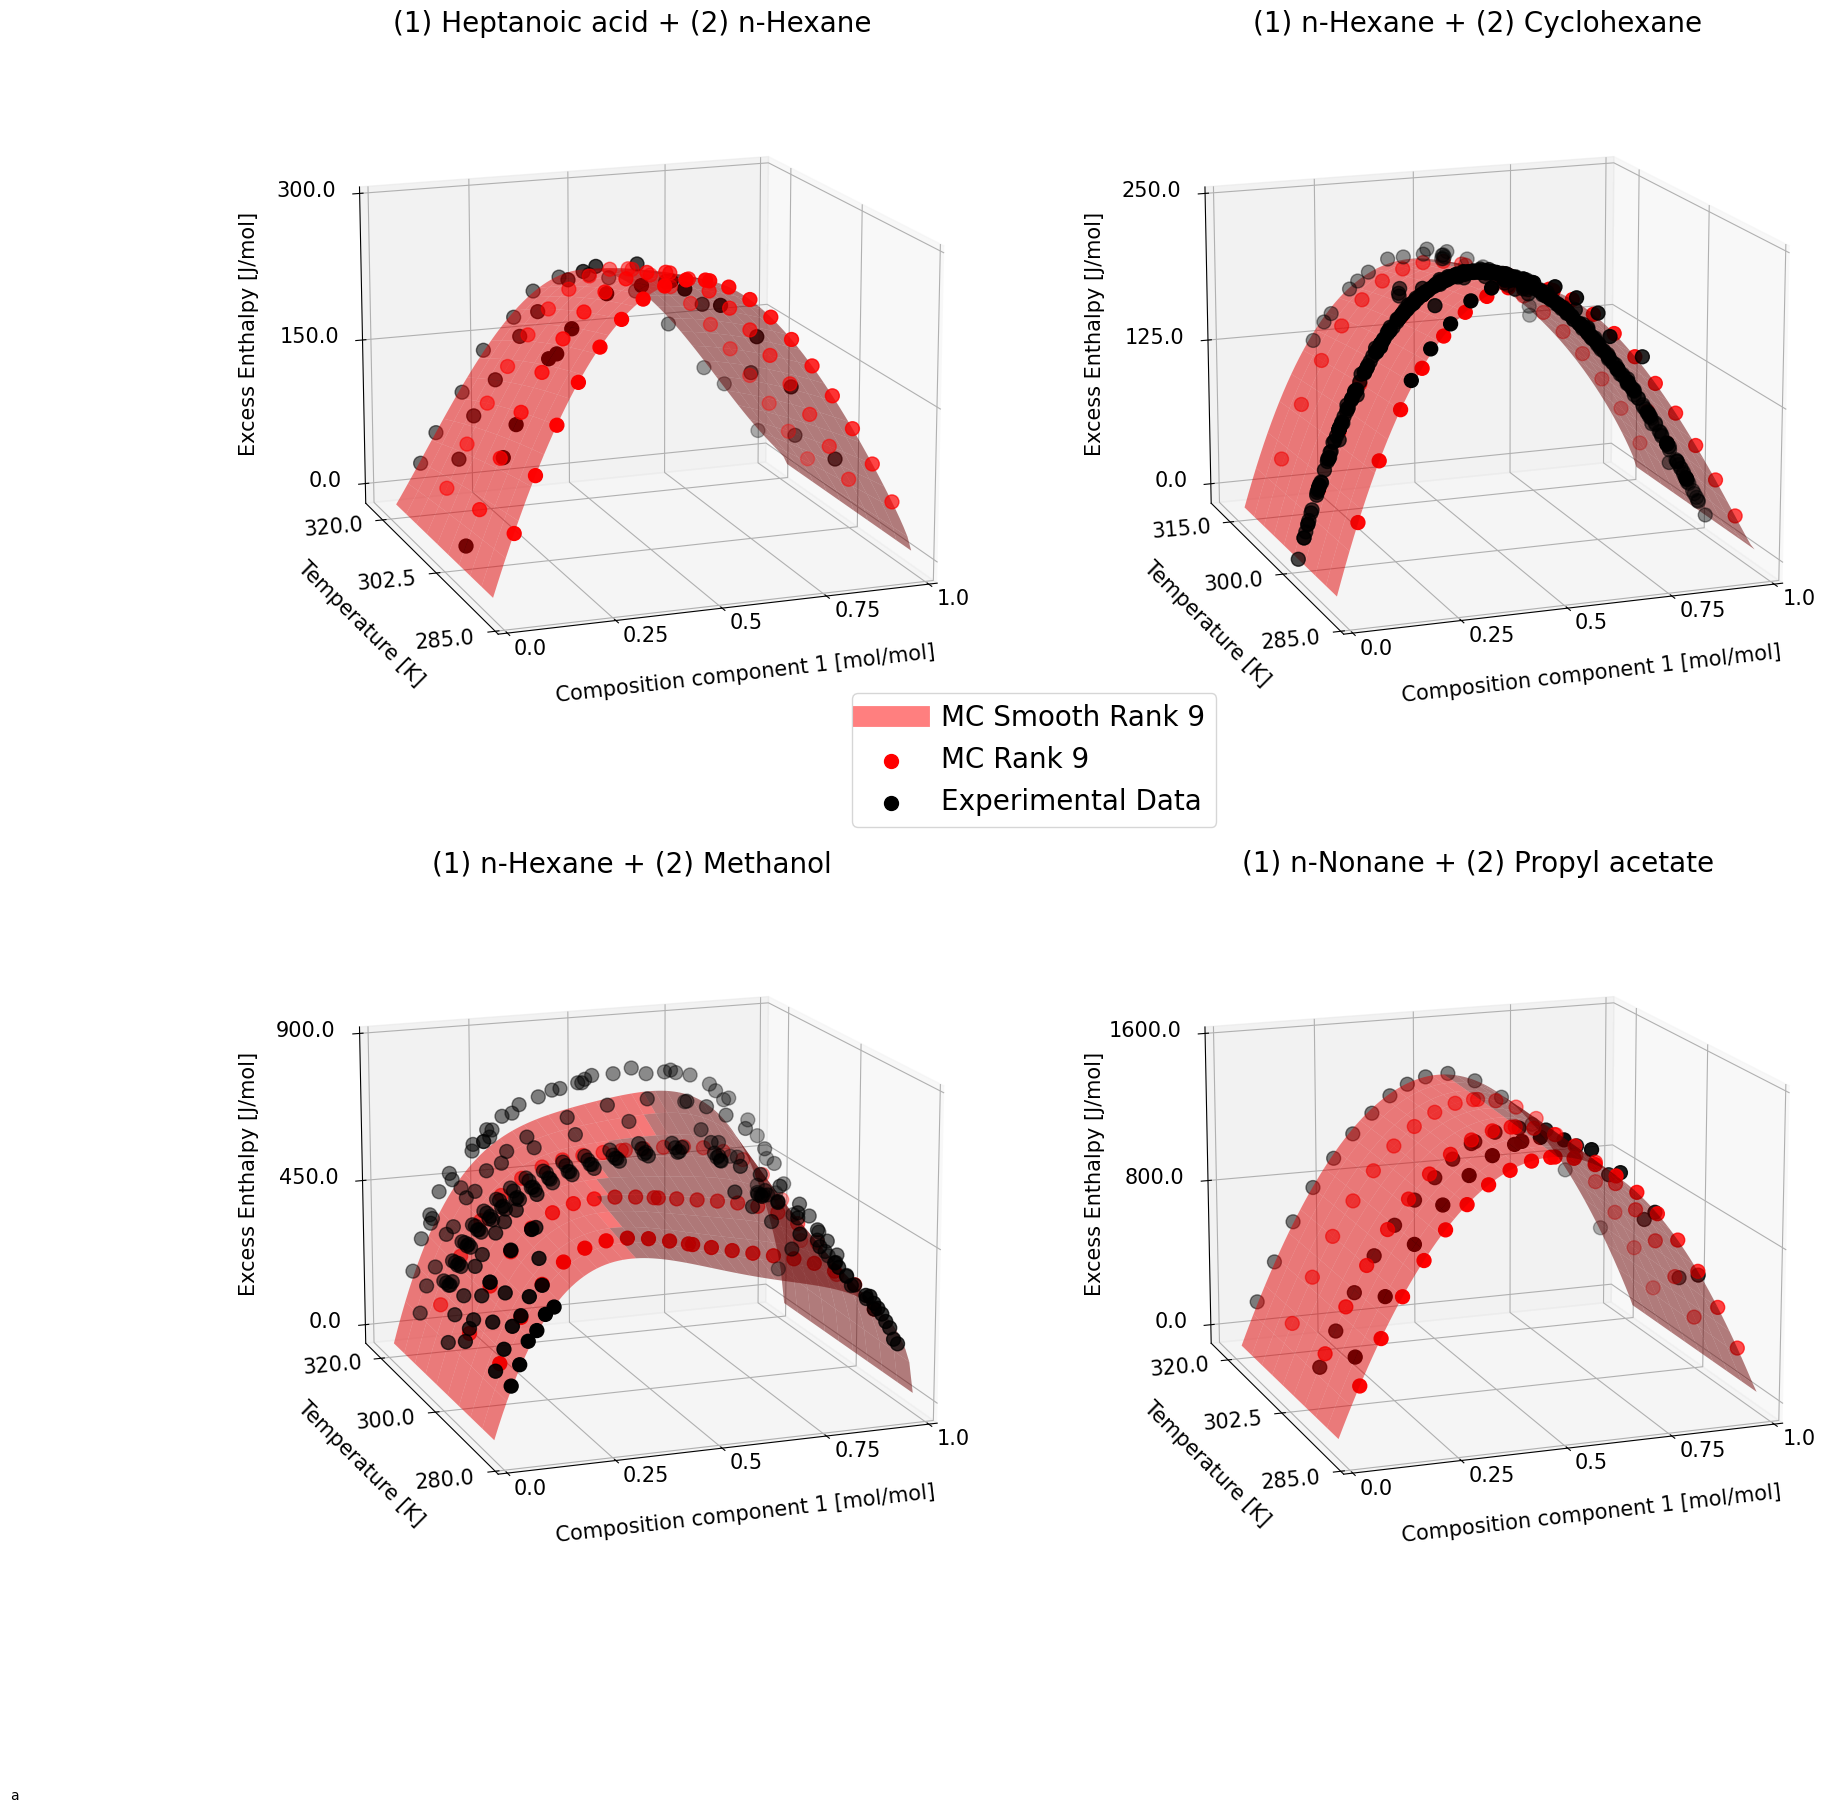

In [53]:
fig = plt.figure(figsize=(20, 20))
ax = [fig.add_subplot(int(f'22{i+1}'), projection='3d') for i in range(Idx_plot.shape[0])]
for i in range(Idx_plot.shape[0]):
    mixi = f'{post_obj.c_all[Idx_plot[i,0]]} + {post_obj.c_all[Idx_plot[i,1]]}'
    y_idx = exp_mix == mixi

    y = data_dict['y_exp'][y_idx]
    T = data_dict['T'][y_idx]
    x = data_dict['x'][y_idx]
    c1 = data_dict['c1'][y_idx][0]
    c2 = data_dict['c2'][y_idx][0]

    mix_UNIFAC = UNIFAC_mix == mixi
    y_UNIFAC = df_UNIFAC['UNIFAC_DMD [J/mol]'][mix_UNIFAC].to_numpy()
    x_UNIFAC = df_UNIFAC['Composition component 1 [mol/mol]'][mix_UNIFAC].to_numpy()
    T_UNIFAC = df_UNIFAC['Temperature [K]'][mix_UNIFAC].to_numpy()

    T_min = min(np.min(T), np.min(T2_int))
    T_max = max(np.max(T), np.max(T2_int))
    T_plot = np.linspace(T_min, T_max, 10)
    x_plot = np.linspace(0, 1, 101)
    x_plot_grid, T_plot_grid = np.meshgrid(x_plot, T_plot)

    K_plot_MC = post_obj.K(x_plot_grid.flatten(), x_MC, T_plot_grid.flatten(), T_MC)

    y_MC_grid = (K_plot_MC @ K_MC_inv @ y_MC_interps_plot[:,i]).reshape(x_plot_grid.shape)
    if i == 1:
        p1 = ax[i].plot_surface(x_plot_grid, T_plot_grid, y_MC_grid, color='red', alpha=0.5, label='MC Rank 9')
    else:
        ax[i].plot_surface(x_plot_grid, T_plot_grid, y_MC_grid, color='red', alpha=0.5, label='MC Rank 9')
    p2 = ax[i].scatter(x_MC, T_MC, y_MC_interps_plot[:,i], color='r', label='MC Rank 9', s=100)
    unique_T_uni = np.unique(T_UNIFAC)
    unique_T_uni = np.concatenate([unique_T_uni.astype(int)+0.15,
                                    unique_T_uni.astype(int)+1.15])
    unique_T_uni = np.unique(unique_T_uni)
    unique_T_uni = unique_T_uni[np.sum(np.abs(unique_T_uni[:,np.newaxis]-T_UNIFAC[np.newaxis,:])<=0.5, axis=1)>0]
    p4 = ax[i].scatter(x, T, y, color='k', label='Experimental Data', s=100)
    ax[i].view_init(15,70+180)
    ax[i].set_xlabel('Composition component 1 [mol/mol]', fontsize=15, labelpad=15)
    ax[i].set_ylabel('Temperature [K]', fontsize=15, labelpad=20)
    ax[i].set_zlabel('Excess Enthalpy [J/mol]', rotation=90, fontsize=15, labelpad=35)

    # Set the rotation of the z-axis label (0 degrees means horizontal)
    ax[i].zaxis.set_rotate_label(False)  # disable automatic rotation

    y_ticks = ax[i].get_yticks()
    y_ticks = np.linspace(y_ticks[0], y_ticks[-1], 3).round(2)
    ax[i].set_yticks(y_ticks, labels=y_ticks, rotation=5,
                    verticalalignment='baseline',
                    horizontalalignment='right',
                    fontsize=15)

    x_ticks = ax[i].get_xticks().round(2)
    x_ticks = np.linspace(0, 1, 5).round(2)
    ax[i].set_xticks(x_ticks, labels=x_ticks, rotation=0,
                    verticalalignment='baseline',
                    horizontalalignment='left',
                    fontsize=15)

    z_ticks = ax[i].get_zticks()
    z_ticks = np.linspace(0, z_ticks[-1], 3).round(2)
    ax[i].set_zticks(z_ticks, labels=z_ticks, rotation=0,
                    verticalalignment='center',
                    horizontalalignment='right',
                    fontsize=15)
    ax[i].set_title(f'(1) {c1} + (2) {c2}', fontsize=20)

    zlim = list(ax[i].get_zlim())
    zlim[0] = zlim[0]
    ylim = list(ax[i].get_ylim())
    ylim[-1] = ylim[-1] + 5

    ax[i].set_zlim(zlim)
    ax[i].set_ylim(ylim)
    ax[i].set_xlim([0, 1])

custom_lines = Line2D([0], [0], marker='', color='red', alpha=0.5, markersize=10, label='Red (Alpha=0.5)', linestyle='-', linewidth=15)

fig.legend([custom_lines, p2, p4], 
           ['MC Smooth Rank 9', 'MC Rank 9', 'Experimental Data'], 
           loc='center right', fontsize=20,
           bbox_to_anchor=(0.6, 0.52))
fig.text(-0.01, 0, 'a')

plt.savefig(f'{post_obj.path}/9/3D_plots_training_smooth_T.png', bbox_inches='tight', dpi=500)

In [54]:
mix_plot = np.array(['n-Hexane + 2-Propanol',
                     'Toluene + 2-Pentanol',
                     'Ethanol + 1-Pentanol',
                     'Butanone + 2-Butanol'])
c1_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,0][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
c2_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,1][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
Idx_plot = np.stack((c1_plot, c2_plot), axis=1)

In [55]:
y_MC_interps_plot = post_obj.extract_interps(A=A,Idx=Idx_plot)[rank_idx]

In [56]:
data_dict = post_obj.get_testing_values(A=A)

In [58]:
exp_mix = np.char.add(np.char.add(data_dict['c1'], ' + '), data_dict['c2'])

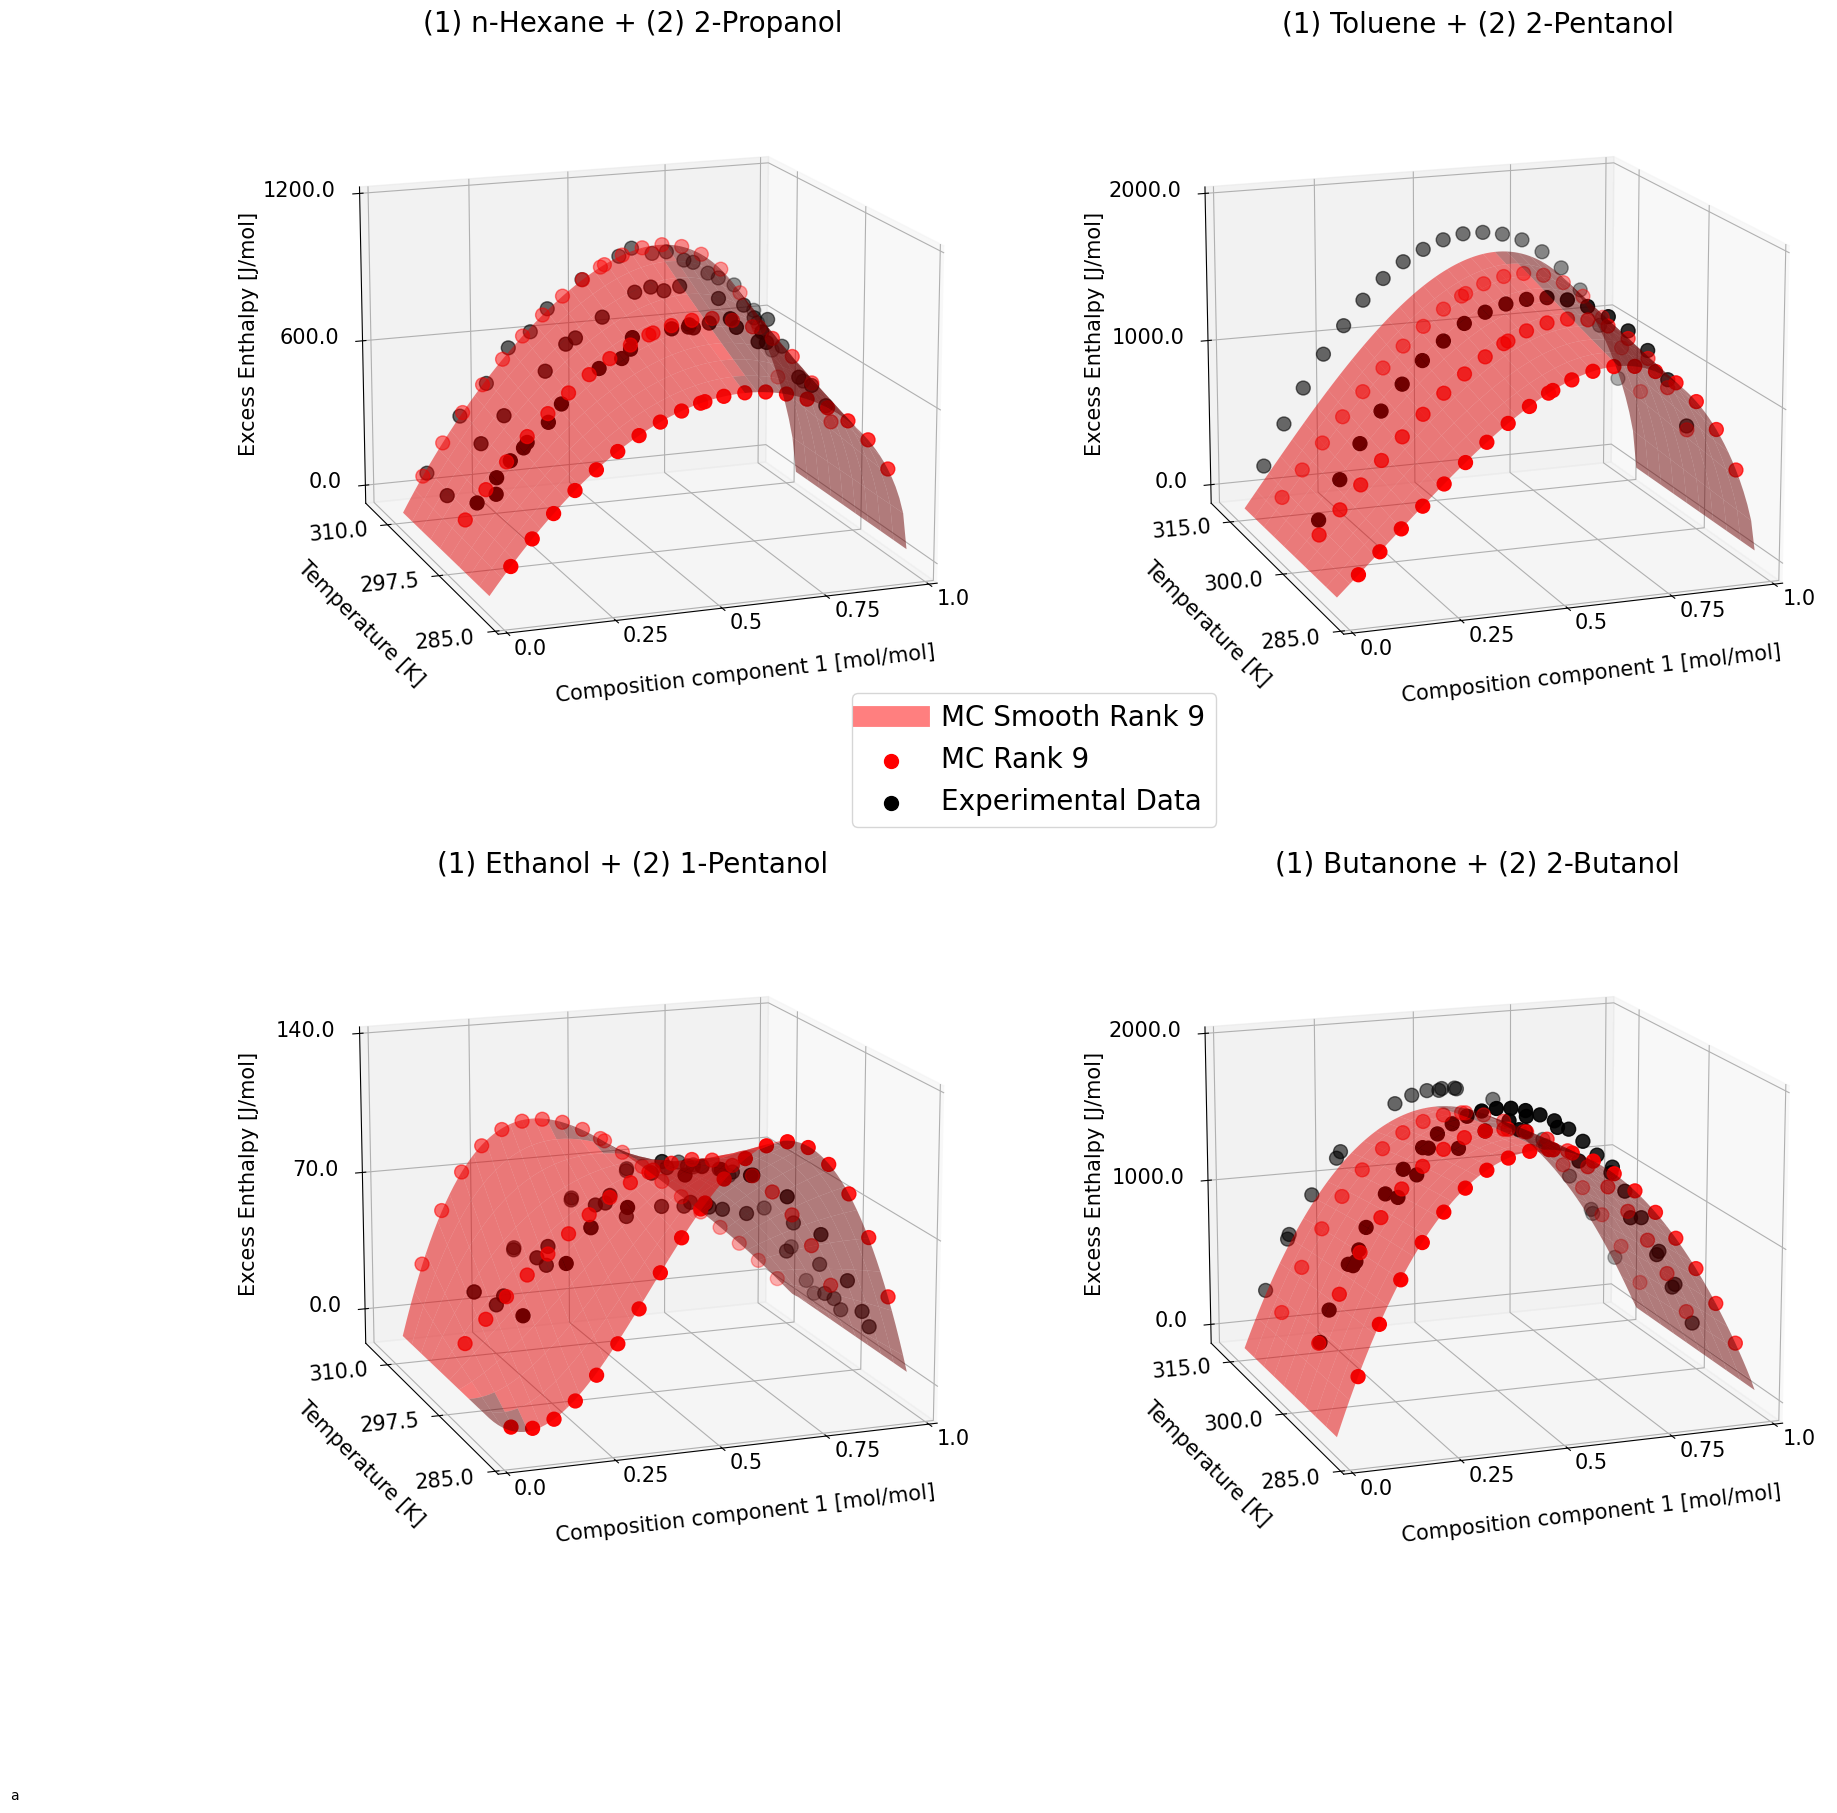

In [60]:
fig = plt.figure(figsize=(20, 20))
ax = [fig.add_subplot(int(f'22{i+1}'), projection='3d') for i in range(Idx_plot.shape[0])]
for i in range(Idx_plot.shape[0]):
    mixi = f'{post_obj.c_all[Idx_plot[i,0]]} + {post_obj.c_all[Idx_plot[i,1]]}'
    y_idx = exp_mix == mixi

    y = data_dict['y_exp'][y_idx]
    T = data_dict['T'][y_idx]
    x = data_dict['x'][y_idx]
    c1 = data_dict['c1'][y_idx][0]
    c2 = data_dict['c2'][y_idx][0]

    mix_UNIFAC = UNIFAC_mix == mixi
    y_UNIFAC = df_UNIFAC['UNIFAC_DMD [J/mol]'][mix_UNIFAC].to_numpy()
    x_UNIFAC = df_UNIFAC['Composition component 1 [mol/mol]'][mix_UNIFAC].to_numpy()
    T_UNIFAC = df_UNIFAC['Temperature [K]'][mix_UNIFAC].to_numpy()

    T_min = min(np.min(T), np.min(T2_int))
    T_max = max(np.max(T), np.max(T2_int))
    T_plot = np.linspace(T_min, T_max, 10)
    x_plot = np.linspace(0, 1, 101)
    x_plot_grid, T_plot_grid = np.meshgrid(x_plot, T_plot)

    K_plot_MC = post_obj.K(x_plot_grid.flatten(), x_MC, T_plot_grid.flatten(), T_MC)

    y_MC_grid = (K_plot_MC @ K_MC_inv @ y_MC_interps_plot[:,i]).reshape(x_plot_grid.shape)
    if i == 1:
        p1 = ax[i].plot_surface(x_plot_grid, T_plot_grid, y_MC_grid, color='red', alpha=0.5, label='MC Rank 9')
    else:
        ax[i].plot_surface(x_plot_grid, T_plot_grid, y_MC_grid, color='red', alpha=0.5, label='MC Rank 9')
    p2 = ax[i].scatter(x_MC, T_MC, y_MC_interps_plot[:,i], color='r', label='MC Rank 9', s=100)
    unique_T_uni = np.unique(T_UNIFAC)
    unique_T_uni = np.concatenate([unique_T_uni.astype(int)+0.15,
                                    unique_T_uni.astype(int)+1.15])
    unique_T_uni = np.unique(unique_T_uni)
    unique_T_uni = unique_T_uni[np.sum(np.abs(unique_T_uni[:,np.newaxis]-T_UNIFAC[np.newaxis,:])<=0.5, axis=1)>0]
    p4 = ax[i].scatter(x, T, y, color='k', label='Experimental Data', s=100)
    ax[i].view_init(15,70+180)
    ax[i].set_xlabel('Composition component 1 [mol/mol]', fontsize=15, labelpad=15)
    ax[i].set_ylabel('Temperature [K]', fontsize=15, labelpad=20)
    ax[i].set_zlabel('Excess Enthalpy [J/mol]', rotation=90, fontsize=15, labelpad=35)

    # Set the rotation of the z-axis label (0 degrees means horizontal)
    ax[i].zaxis.set_rotate_label(False)  # disable automatic rotation

    y_ticks = ax[i].get_yticks()
    y_ticks = np.linspace(y_ticks[0], y_ticks[-1], 3).round(2)
    ax[i].set_yticks(y_ticks, labels=y_ticks, rotation=5,
                    verticalalignment='baseline',
                    horizontalalignment='right',
                    fontsize=15)

    x_ticks = ax[i].get_xticks().round(2)
    x_ticks = np.linspace(0, 1, 5).round(2)
    ax[i].set_xticks(x_ticks, labels=x_ticks, rotation=0,
                    verticalalignment='baseline',
                    horizontalalignment='left',
                    fontsize=15)

    z_ticks = ax[i].get_zticks()
    z_ticks = np.linspace(0, z_ticks[-1], 3).round(2)
    ax[i].set_zticks(z_ticks, labels=z_ticks, rotation=0,
                    verticalalignment='center',
                    horizontalalignment='right',
                    fontsize=15)
    ax[i].set_title(f'(1) {c1} + (2) {c2}', fontsize=20)

    zlim = list(ax[i].get_zlim())
    zlim[0] = zlim[0]
    ylim = list(ax[i].get_ylim())
    ylim[-1] = ylim[-1] + 5

    ax[i].set_zlim(zlim)
    ax[i].set_ylim(ylim)
    ax[i].set_xlim([0, 1])

custom_lines = Line2D([0], [0], marker='', color='red', alpha=0.5, markersize=10, label='Red (Alpha=0.5)', linestyle='-', linewidth=15)

fig.legend([custom_lines, p2, p4], 
           ['MC Smooth Rank 9', 'MC Rank 9', 'Experimental Data'], 
           loc='center right', fontsize=20,
           bbox_to_anchor=(0.6, 0.52))
fig.text(-0.01, 0, 'a')

plt.savefig(f'{post_obj.path}/9/3D_plots_testing_smooth_T.png', bbox_inches='tight', dpi=500)

In [6]:
y_MC_interps = post_obj.extract_interps(A=A, Idx=post_obj.testing_indices)[rank_idx]
data_dict = post_obj.get_testing_values(A=A)

In [9]:
T_unique = np.unique(data_dict['T'])
T_unique = np.concatenate([T_unique.astype(int)+0.15,
                           T_unique.astype(int)+1.15])
T_unique = np.unique(T_unique)
T_unique = T_unique[np.sum(np.abs(T_unique[:,np.newaxis]-data_dict['T'][np.newaxis,:])<=0.5, axis=1)>0]

In [13]:
mix_all = np.char.add(np.char.add(data_dict['c1'], ' + '), data_dict['c2'])

In [57]:
mix_plot = np.array([['n-Pentane', 'Propanone'],
                     ['Butylamine', '1-Propanol'],
                     ['Butylamine', '1-Pentanol'],
                     ['Propyl acetate', 'Ethanol'],
                     ['n-Hexane', 'Aniline'],
                     ['n-Hexane', 'Hexylamine'],
                     ['n-Hexane', 'Toluene'],
                     ['Hexylamine', 'Cyclohexane'],
                     ['n-Hexane', 'Isobutanol']])

In [75]:
Idx_plot = post_obj.testing_indices[np.sum(np.char.add(np.char.add(post_obj.c_all[post_obj.testing_indices[:,0]], ' + '),
                                                                    post_obj.c_all[post_obj.testing_indices[:,1]])[:,np.newaxis] == np.char.add(np.char.add(mix_plot[:,0], ' + '), 
                                                                                                                                                            mix_plot[:,1])[np.newaxis,:], axis=1)>0]
y_MC_interps_plot = post_obj.extract_interps(A=A, Idx=Idx_plot)[rank_idx]

In [77]:
x2_int = np.array(json.load(open(post_obj.data_file, 'r'))['x2_int'])
T2_int = np.array(json.load(open(post_obj.data_file, 'r'))['T2_int'])
v_MC = json.load(open(post_obj.data_file, 'r'))['v_MC']
jitter = json.load(open(post_obj.data_file, 'r'))['jitter']

x_MC = np.concatenate([x2_int for _ in T2_int])
T_MC = np.concatenate([T*np.ones_like(x2_int) for T in T2_int])

K_MC = post_obj.K(x_MC, x_MC, T_MC, T_MC) + (jitter + v_MC)*np.eye(x_MC.size)
L_MC = np.linalg.cholesky(K_MC)
L_MC_inv = np.linalg.inv(L_MC)
K_MC_inv = L_MC_inv.T @ L_MC_inv

del K_MC, L_MC, L_MC_inv

In [78]:
df_UNIFAC = pd.read_excel(post_obj.excel_plots_known, sheet_name='Testing_Plots')
UNIFAC_mix = np.char.add(np.char.add(df_UNIFAC['Component 1'].to_numpy().astype(str), ' + '), df_UNIFAC['Component 2'].to_numpy().astype(str))

In [ ]:
matplotlib.use('qt5agg')
%matplotlib inline

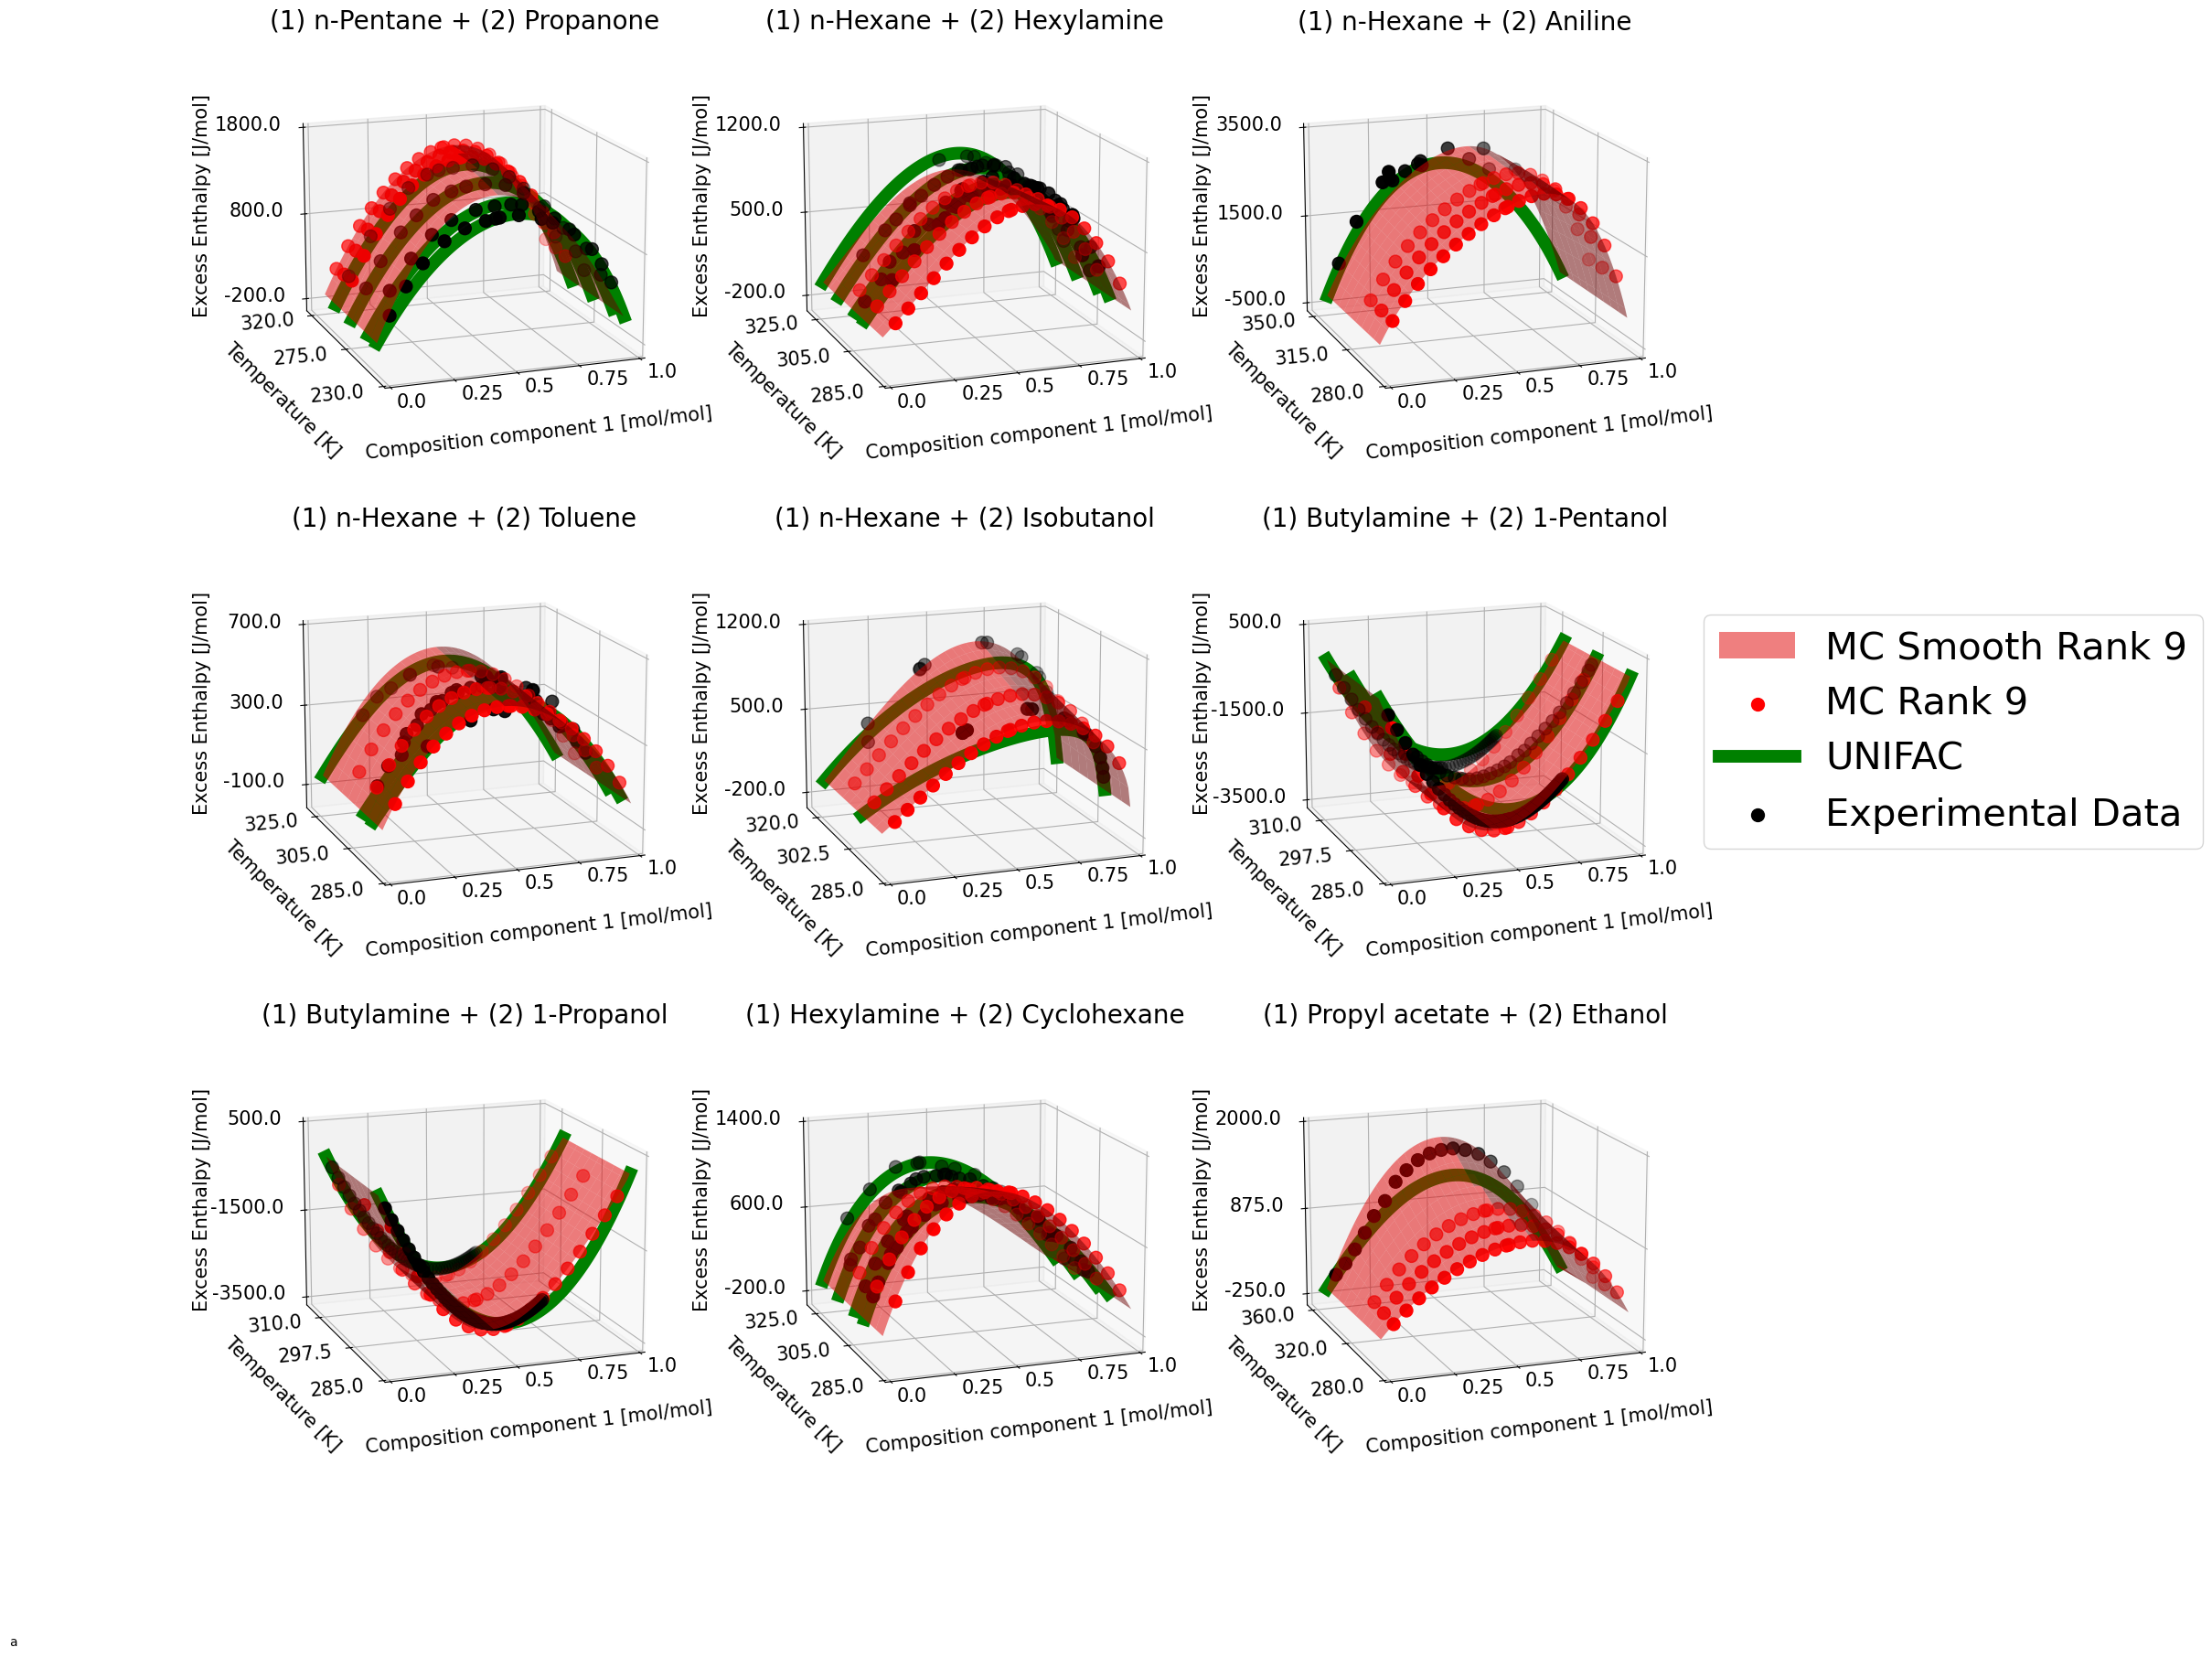

In [174]:
fig = plt.figure(figsize=(20, 20))
ax = [fig.add_subplot(int(f'33{i+1}'), projection='3d') for i in range(Idx_plot.shape[0])]

for i in range(Idx_plot.shape[0]):
    mixi = f'{post_obj.c_all[Idx_plot[i,0]]} + {post_obj.c_all[Idx_plot[i,1]]}'
    y_idx = mix_all == mixi

    y = data_dict['y_exp'][y_idx]
    T = data_dict['T'][y_idx]
    x = data_dict['x'][y_idx]
    c1 = data_dict['c1'][y_idx][0]
    c2 = data_dict['c2'][y_idx][0]

    mix_UNIFAC = UNIFAC_mix == mixi
    y_UNIFAC = df_UNIFAC['UNIFAC_DMD [J/mol]'][mix_UNIFAC].to_numpy()
    x_UNIFAC = df_UNIFAC['Composition component 1 [mol/mol]'][mix_UNIFAC].to_numpy()
    T_UNIFAC = df_UNIFAC['Temperature [K]'][mix_UNIFAC].to_numpy()

    T_min = min(np.min(T), np.min(T2_int))
    T_max = max(np.max(T), np.max(T2_int))
    T_plot = np.linspace(T_min, T_max, 10)
    x_plot = np.linspace(0, 1, 101)
    x_plot_grid, T_plot_grid = np.meshgrid(x_plot, T_plot)

    K_plot_MC = post_obj.K(x_plot_grid.flatten(), x_MC, T_plot_grid.flatten(), T_MC)

    y_MC_grid = (K_plot_MC @ K_MC_inv @ y_MC_interps_plot[:,i]).reshape(x_plot_grid.shape)

    p1 = ax[i].plot_surface(x_plot_grid, T_plot_grid, y_MC_grid, color='red', alpha=0.5, label='MC Rank 9')
    p2 = ax[i].scatter(x_MC, T_MC, y_MC_interps_plot[:,i], color='r', label='MC Rank 9', s=100)
    unique_T_uni = np.unique(T_UNIFAC)
    unique_T_uni = np.concatenate([unique_T_uni.astype(int)+0.15,
                                    unique_T_uni.astype(int)+1.15])
    unique_T_uni = np.unique(unique_T_uni)
    unique_T_uni = unique_T_uni[np.sum(np.abs(unique_T_uni[:,np.newaxis]-T_UNIFAC[np.newaxis,:])<=0.5, axis=1)>0]
    for T_un in unique_T_uni:
        idx_uni_T = np.abs(T_UNIFAC - T_un)<=0.5
        x_uni = x_UNIFAC[idx_uni_T]
        y_uni = y_UNIFAC[idx_uni_T]
        T_uni = T_UNIFAC[idx_uni_T]
        p3 = ax[i].plot(x_uni, T_uni, y_uni, label='UNIFAC', color='g', linewidth=10)
    p4 = ax[i].scatter(x, T, y, color='k', label='Experimental Data', s=100)
    ax[i].view_init(15,70+180)
    ax[i].set_xlabel('Composition component 1 [mol/mol]', fontsize=15, labelpad=15)
    ax[i].set_ylabel('Temperature [K]', fontsize=15, labelpad=20)
    ax[i].set_zlabel('Excess Enthalpy [J/mol]', rotation=90, fontsize=15, labelpad=35)

    # Set the rotation of the z-axis label (0 degrees means horizontal)
    ax[i].zaxis.set_rotate_label(False)  # disable automatic rotation

    y_ticks = ax[i].get_yticks()
    y_ticks = np.linspace(y_ticks[0], y_ticks[-1], 3).round(2)
    ax[i].set_yticks(y_ticks, labels=y_ticks, rotation=5,
                    verticalalignment='baseline',
                    horizontalalignment='right',
                    fontsize=15)

    x_ticks = ax[i].get_xticks().round(2)
    x_ticks = np.linspace(0, 1, 5).round(2)
    ax[i].set_xticks(x_ticks, labels=x_ticks, rotation=0,
                    verticalalignment='baseline',
                    horizontalalignment='left',
                    fontsize=15)

    z_ticks = ax[i].get_zticks()
    z_ticks = np.linspace(z_ticks[0], z_ticks[-1], 3).round(2)
    ax[i].set_zticks(z_ticks, labels=z_ticks, rotation=0,
                    verticalalignment='center',
                    horizontalalignment='right',
                    fontsize=15)
    ax[i].set_title(f'(1) {c1} + (2) {c2}', fontsize=20)

    zlim = list(ax[i].get_zlim())
    zlim[0] = zlim[0] - 100
    ylim = list(ax[i].get_ylim())
    ylim[-1] = ylim[-1] + 5

    ax[i].set_zlim(zlim)
    ax[i].set_ylim(ylim)
    ax[i].set_xlim([0, 1])

fig.legend([p1, p2, p3[0], p4], 
           ['MC Smooth Rank 9', 'MC Rank 9', 'UNIFAC', 'Experimental Data'], 
           loc='center right', fontsize=30,
           bbox_to_anchor=(1.2, 0.5))
fig.text(-0.01, 0, 'a')
plt.savefig(f'{post_obj.path}/9/3D_plots_testing_Data_plots.png', bbox_inches='tight', dpi=500)

In [175]:
data_dict_train = post_obj.get_reconstructed_values(A=A)

In [177]:
np.min(data_dict_train['T']), np.max(data_dict_train['T'])

(280.15, 333.15)

In [183]:
T_unique_train = np.unique(data_dict_train['T'])
T_unique_train = np.concatenate([T_unique_train.astype(int)+0.15,
                           T_unique_train.astype(int)+1.15])
T_unique_train = np.unique(T_unique_train)
T_unique_train = T_unique_train[np.sum(np.abs(T_unique_train[:,np.newaxis]-data_dict_train['T'][np.newaxis,:])<=0.5, axis=1)>0]

In [186]:
T_unique_all = np.concatenate([T_unique_train, T_unique])
T_unique_all = np.unique(T_unique_all)

In [189]:
num_training_data = []
num_testing_data = []
MAE_testing = []
MAE_training = []

for T_un in T_unique_all:
    idx_train = np.abs(data_dict_train['T'] - T_un)<=0.5
    idx_test = np.abs(data_dict['T'] - T_un)<=0.5
    num_training_data += [np.sum(idx_train)]
    num_testing_data += [np.sum(idx_test)]
    MAE_testing += [np.mean(np.abs(data_dict['y_exp'][idx_test] - data_dict['y_MC'][idx_test,rank_idx]))]
    MAE_training += [np.mean(np.abs(data_dict_train['y_exp'][idx_train] - data_dict_train['y_MC'][idx_train,rank_idx]))]

/home/garren/anaconda3/envs/cmdstan_condaforge/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/garren/anaconda3/envs/cmdstan_condaforge/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/tmp/ipykernel_880349/3236636009.py:3: RuntimeWarning: divide by zero encountered in log
  p1 = ax.plot(T_unique_all, np.log(num_training_data), '.k', label='Number of Training datapoints', markersize=markersize)
/tmp/ipykernel_880349/3236636009.py:4: RuntimeWarning: divide by zero encountered in log
  p2 = ax.plot(T_unique_all, np.log(num_testing_data), '*k', label='Number of Testing datapoints', markersize=markersize)


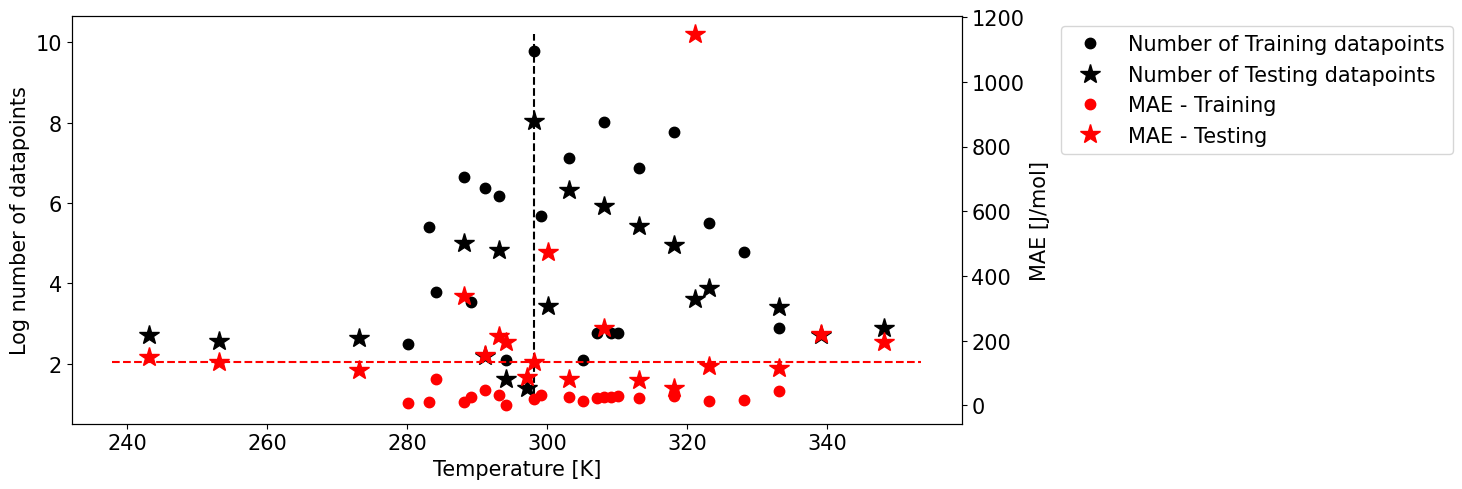

In [231]:
fig,ax = plt.subplots(figsize=(15,5))
markersize=15
p1 = ax.plot(T_unique_all, np.log(num_training_data), '.k', label='Number of Training datapoints', markersize=markersize)
p2 = ax.plot(T_unique_all, np.log(num_testing_data), '*k', label='Number of Testing datapoints', markersize=markersize)
ax.set_xlabel('Temperature [K]', fontsize=15)
ax.set_ylabel('Log number of datapoints', fontsize=15)
ax.plot([298.15, 298.15], ax.get_ylim(), '--k')
axtwin = ax.twinx()
p3 = axtwin.plot(T_unique_all, MAE_training, '.r', label='MAE - Training', markersize=markersize)
p4 = axtwin.plot(T_unique_all, MAE_testing, '*r', label='MAE - Testing', markersize=markersize)
plt.ylabel('MAE [J/mol]', fontsize=15)

ax.legend([p1[0], p2[0], p3[0], p4[0]],
           ['Number of Training datapoints', 'Number of Testing datapoints', 'MAE - Training', 'MAE - Testing'],
           bbox_to_anchor=(1.1,1), loc='upper left', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
axtwin.tick_params(axis='both', which='major', labelsize=15)
T_idx_298 = np.where(T_unique_all == 298.15)[0][0]
axtwin.plot(axtwin.get_xlim(), [MAE_testing[T_idx_298], MAE_testing[T_idx_298]], '--r')
plt.tight_layout()

plt.savefig(f'{post_obj.path}/MAE_with_temperature.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_880349/1422230279.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(num_training_data), MAE_testing, '.k')


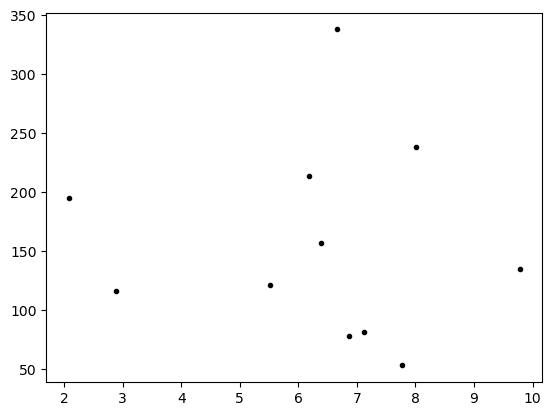

In [232]:
plt.plot(np.log(num_training_data), MAE_testing, '.k')

In [233]:
data_dict_T_dept = post_obj.get_testing_metrics_T_dep(A=A)

In [236]:
T_dep = []
num_mix_comp1 = []
num_mix_comp2 = []
MAE = []
for i in range(data_dict_T_dept['Component 1', '', ''].shape[0]):
    T_dep += [data_dict_T_dept['Temperature [K]', '', ''][i]]
    c1 = data_dict_T_dept['Component 1', '', ''][i]
    c2 = data_dict_T_dept['Component 2', '', ''][i]
    num_mix_comp1 += [np.sum(post_obj.c_all[post_obj.Idx_known[:,0]] == c1)+np.sum(post_obj.c_all[post_obj.Idx_known[:,1]] == c1)]
    num_mix_comp2 += [np.sum(post_obj.c_all[post_obj.Idx_known[:,0]] == c2)+np.sum(post_obj.c_all[post_obj.Idx_known[:,1]] == c2)]
    MAE += [data_dict_T_dept['MC', 'MAE', 9][i]]

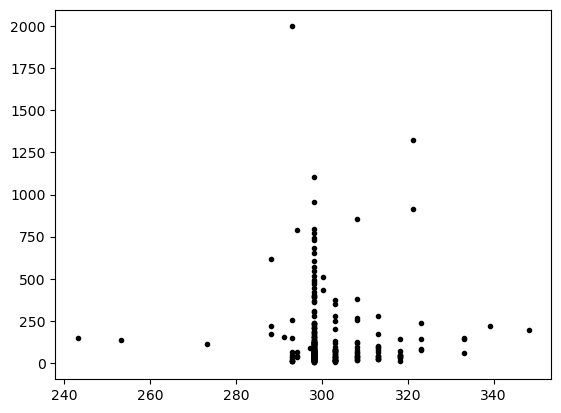

In [237]:
plt.plot(T_dep, MAE, '.k')

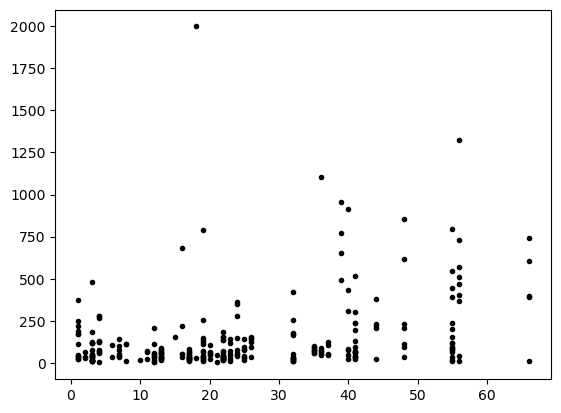

In [240]:
plt.plot(num_mix_comp2, MAE, '.k')

In [253]:
c1_hexyl = data_dict_train['c1']=='Hexylamine'
c2_hexyl = data_dict_train['c2']=='Hexylamine'
c_hexyl = (c1_hexyl.astype(int) + c2_hexyl.astype(int)) == 1

In [254]:
mix_hexyl = np.char.add(np.char.add(data_dict_train['c1'][c_hexyl], ' + '), data_dict_train['c2'][c_hexyl])
uni_mix_hexyl, idx = np.unique(mix_hexyl, return_index=True)
uni_mix_hexyl = uni_mix_hexyl[np.argsort(idx)]

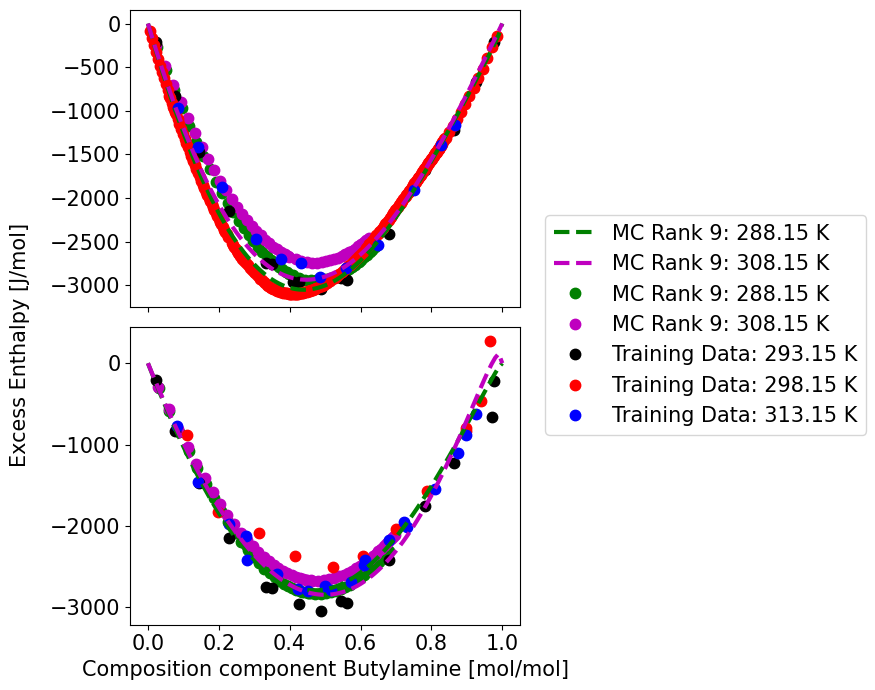

In [342]:
test_T = [288.15, 308.15]
train_T = [293.15, 298.15, 313.15]

mix = np.array([['Butylamine', '1-Propanol'],
                ['Butylamine', '1-Butanol']]) 
Idx_mix = np.array([[np.where(post_obj.c_all == mix[i][j])[0][0] for j in range(mix.shape[1])] for i in range(mix.shape[0])])
y_MC_interps_test = post_obj.extract_interps(A=A, Idx=Idx_mix)[rank_idx]

colours_exp = ['.k', '.r', '.b']
labels_exp = [f'Training Data: {T} K' for T in train_T]
colours_MC = ['--g', '--m']
labels_MC = [f'MC Rank 9: {T} K' for T in test_T]
colours_MC_test = ['.g', '.m']
labels_MC_test = [f'MC Rank 9: {T} K' for T in test_T]

mix = np.char.add(np.char.add(mix[:,0], ' + '), mix[:,1])

x_plot = np.concatenate([np.linspace(0, 1, 101) for _ in test_T])
T_plot = np.concatenate([np.ones(101)*T for T in test_T])
K_plot_MC = post_obj.K(x_plot, x_MC, T_plot, T_MC)

y_MC_plot = K_plot_MC @ K_MC_inv @ y_MC_interps_test

mix_train = np.char.add(np.char.add(data_dict_train['c1'], ' + '), data_dict_train['c2'])
mix_test = np.char.add(np.char.add(data_dict['c1'], ' + '), data_dict['c2'])

fig, ax = plt.subplots(2, 1, figsize=(5, 7), sharex=True)
for i in range(len(mix)):
    m = mix[i]

    xx = data_dict_train['x'][mix_train == m]
    yy = data_dict_train['y_exp'][mix_train == m]
    TT = data_dict_train['T'][mix_train == m]

    p_test_MC = []
    p_test_exp = []
    p_train_exp = []
    
    xx_test = data_dict['x'][mix_test == m]
    yy_test = data_dict['y_exp'][mix_test == m]
    TT_test = data_dict['T'][mix_test == m]

    for j in range(len(test_T)):
        idx_test_T = np.abs(TT_test - test_T[j])<=0.5
        xx_test_T = xx_test[idx_test_T]
        yy_test_T = yy_test[idx_test_T]
        p_test_exp += [ax[i].plot(xx_test_T,yy_test_T, colours_MC_test[j], label=labels_MC_test[j], markersize=15)]
    
    for t in train_T:
        idx = np.abs(TT - t)<=0.5
        xx_T = xx[idx]
        yy_T = yy[idx]
        p_train_exp += [ax[i].plot(xx_T,yy_T, colours_exp[train_T.index(t)], label=labels_exp[train_T.index(t)], markersize=15)]

    for j in range(len(test_T)):
        p_test_MC += [ax[i].plot(x_plot[j*101:(j+1)*101], y_MC_plot[j*101:(j+1)*101,i], colours_MC[j], label=labels_MC[j], linewidth=3)]

fig.legend([p_test_MC[0][0], p_test_MC[1][0], p_test_exp[0][0], p_test_exp[1][0], p_train_exp[0][0], p_train_exp[1][0], p_train_exp[2][0]],
              labels_MC+labels_MC_test+labels_exp,
              bbox_to_anchor=(1,0.7), loc='upper left', fontsize=15)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=15)
ax[-1].set_xlabel('Composition component Butylamine [mol/mol]', fontsize=15)
fig.text(-0.05, 0.5, 'Excess Enthalpy [J/mol]', va='center', rotation='vertical', fontsize=15)
plt.tight_layout()

plt.savefig(f'{post_obj.path}/9/Butylamine_mixtures.png', dpi=300, bbox_inches='tight')